In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import jax
import optax
import flax
from flax.training import train_state, checkpoints
from functools import partial

from dataset.chirping_binary import ChirpingBinary
from models.signalprocessing import MambaSP, S4DSP
import training


print(f"JAX devices:{jax.devices()}")

JAX devices:[cuda(id=0), cuda(id=1), cuda(id=2)]


In [2]:
rng_key = jax.random.key(0)
batch_size = 32

episode_duration_s = 1
sample_rate_Hz = 1000
dataset = ChirpingBinary(1, episode_duration_s, sample_rate_Hz, scale=1e20)
model = MambaSP(sample_rate_Hz, state_dim=64, n_layers=4)
model = S4DSP(sample_rate_Hz, state_dim=64, n_layers=4)

2024-01-06 16:34:29.575876: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
optimization_step = jax.jit(
    partial(training.optimization_step, loss_fn=training.signal_mse_loss)
)
get_batch = jax.jit(dataset.get_batch, static_argnames=["batch_size"])


train_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(rng_key, dataset.sample(rng_key)[0]),
    tx=optax.chain(optax.clip(1.0), optax.adam(3e-4, b2=0.95)),
)

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 2.3445961475372314


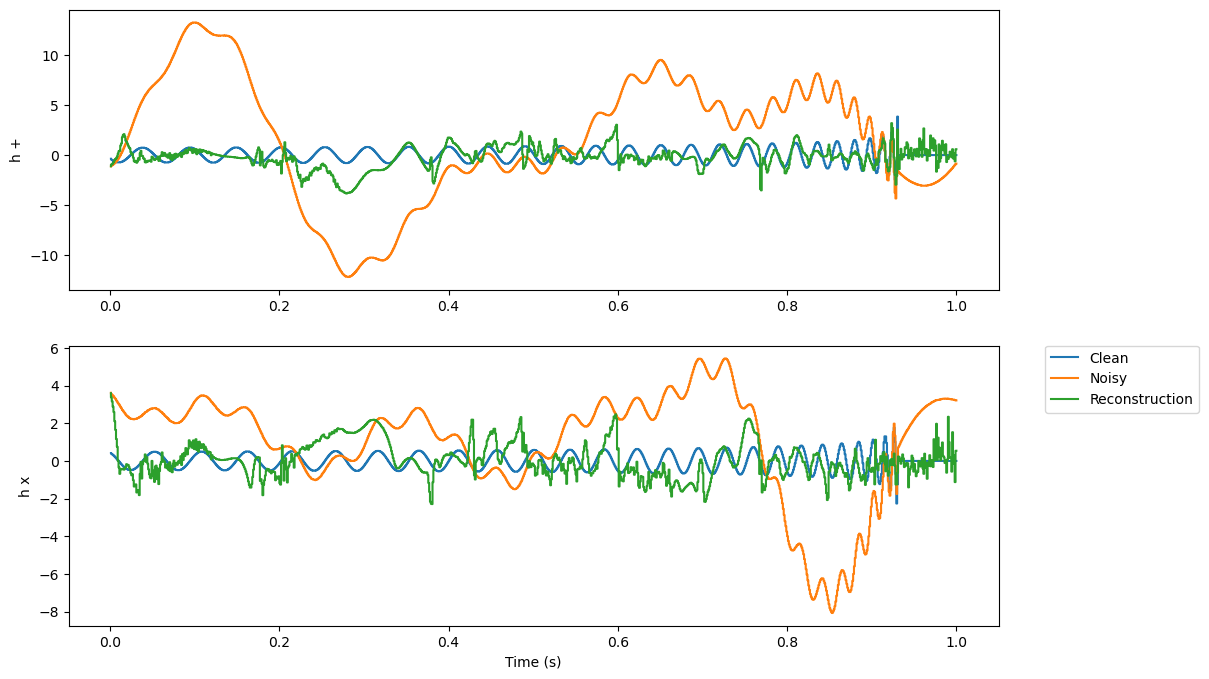

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.7650237679481506


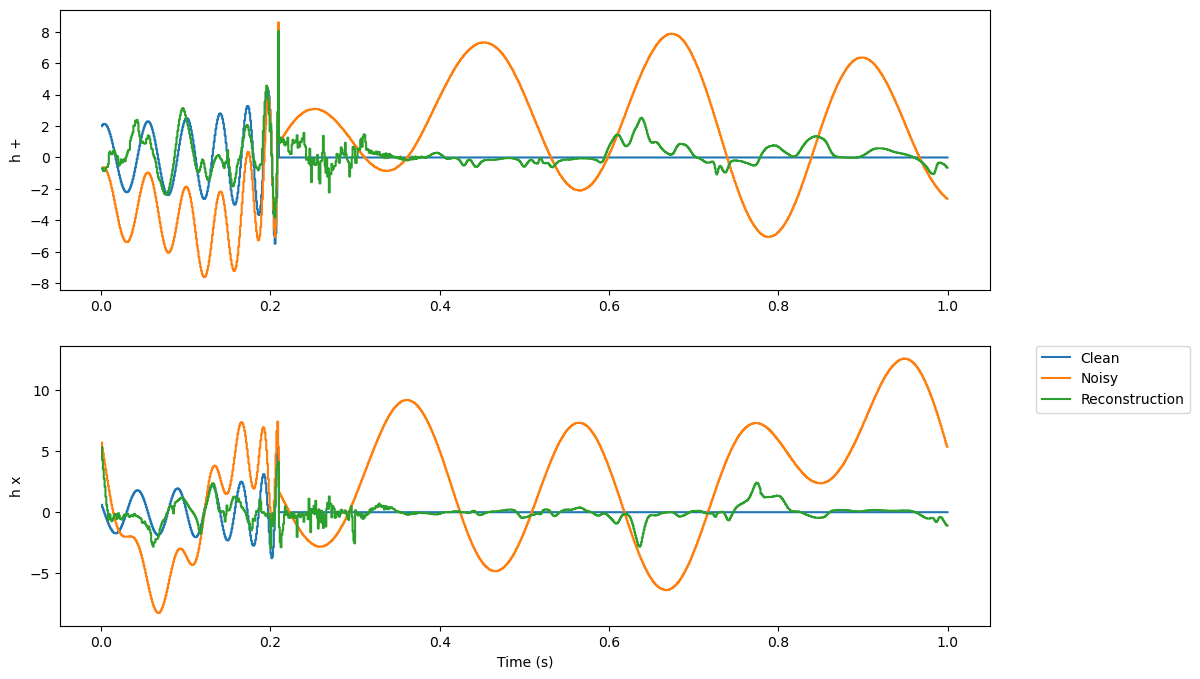

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.6145620942115784


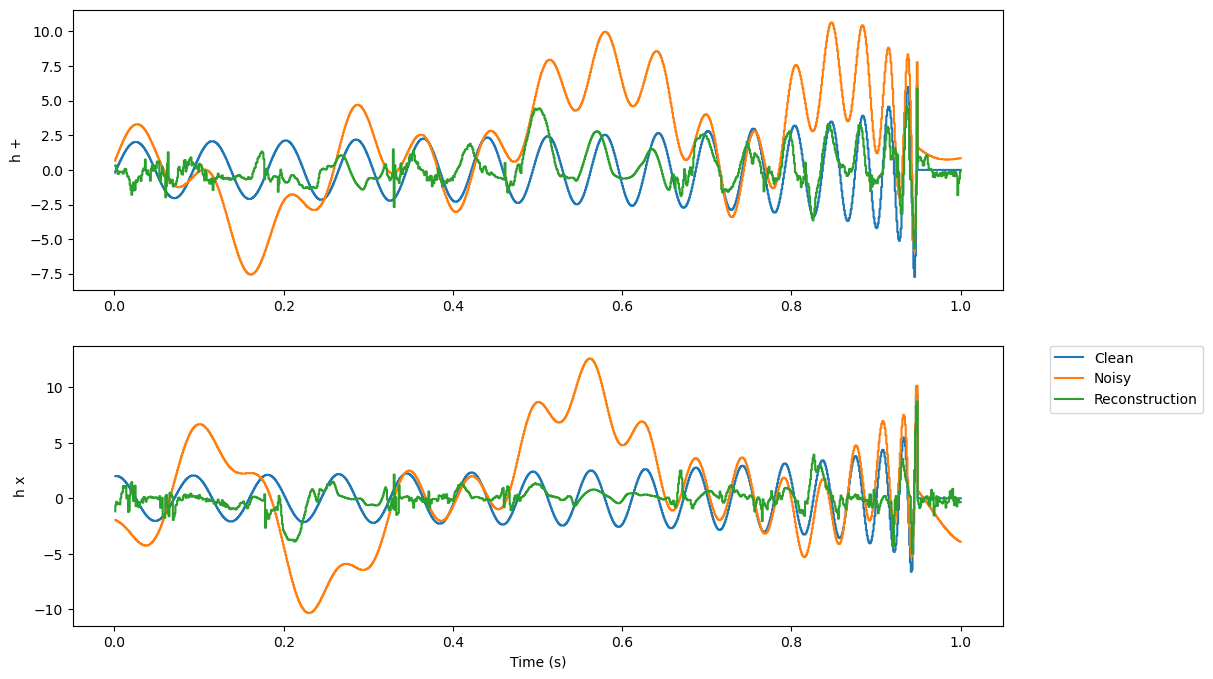

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.571566104888916


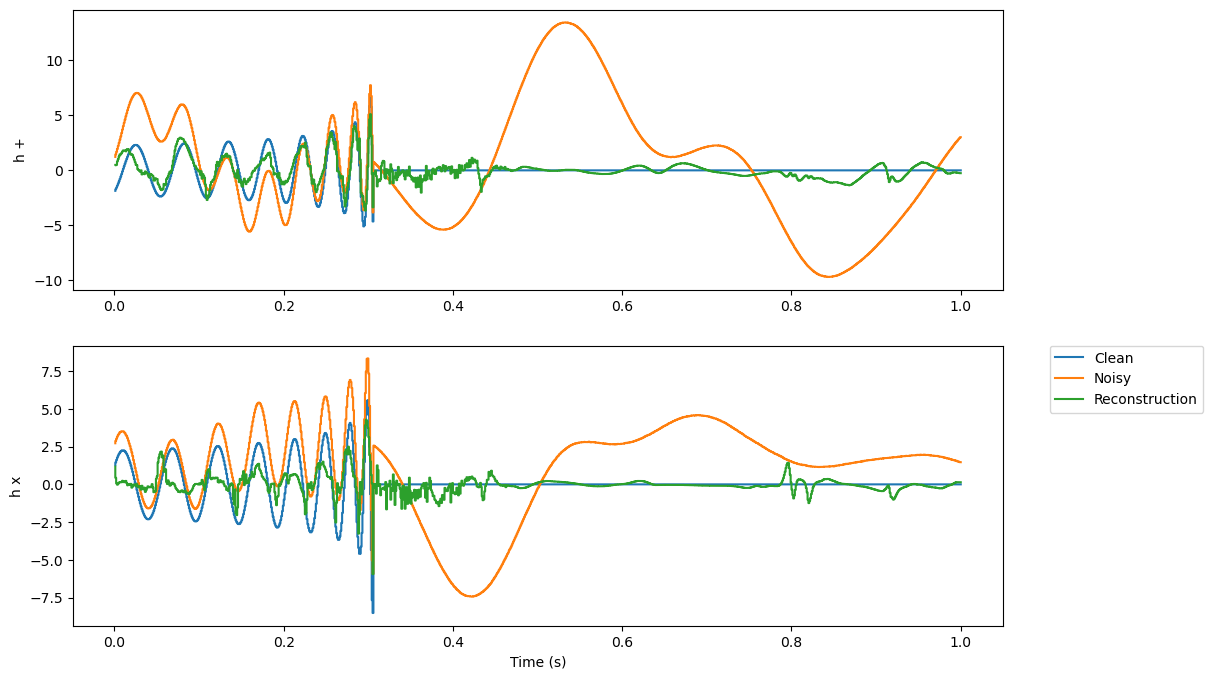

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.5401933193206787


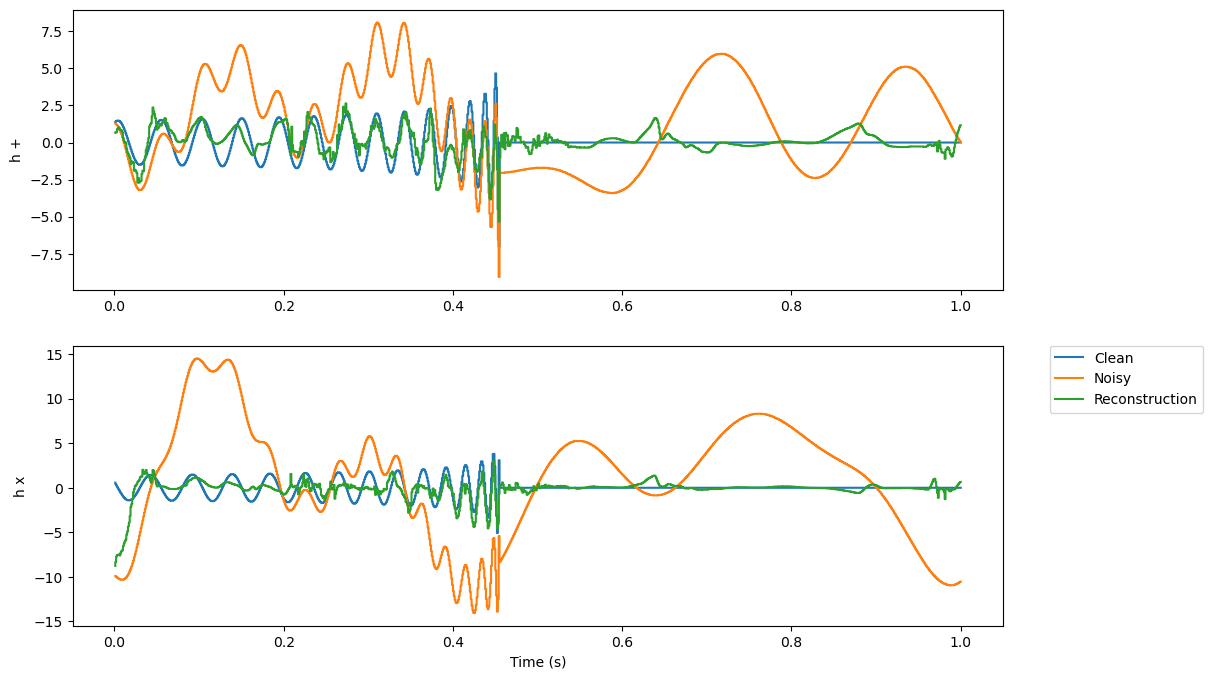

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.5188413858413696


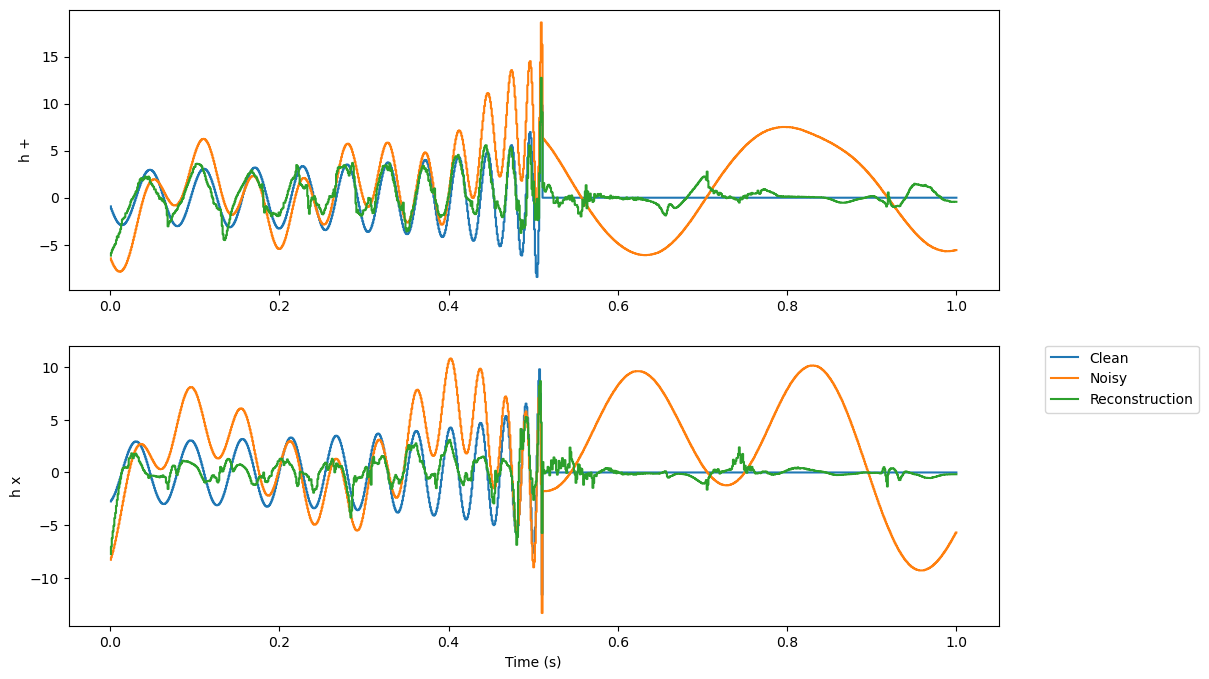

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.507057785987854


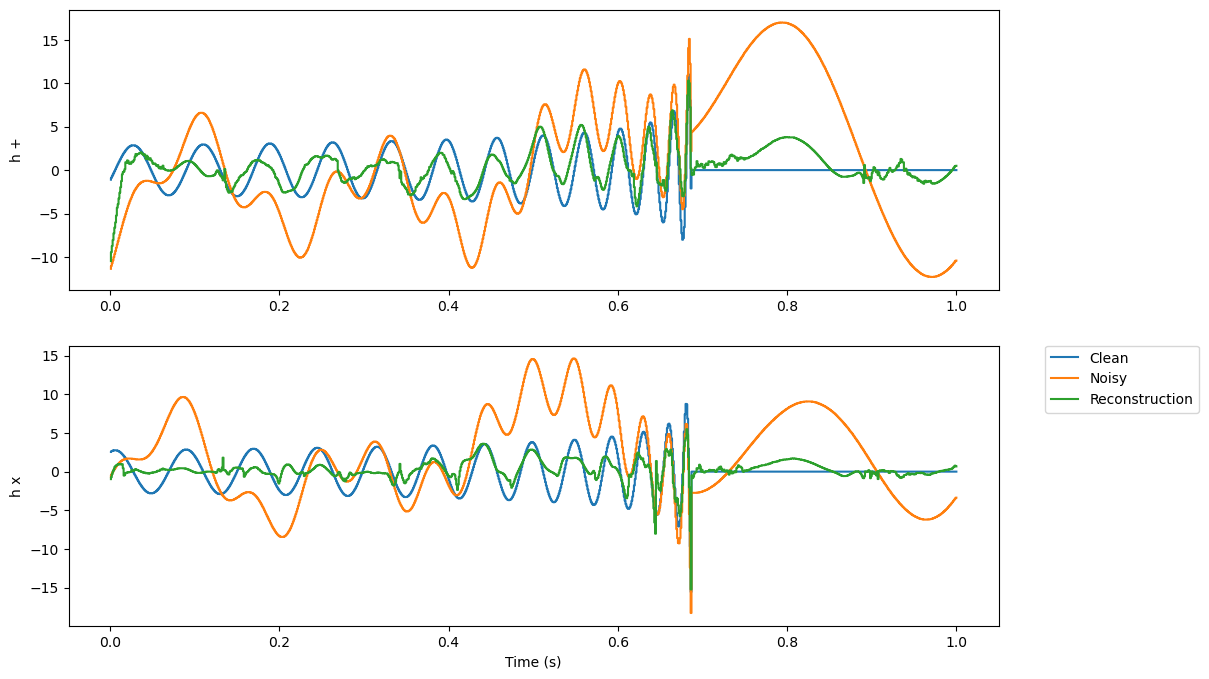

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.4829781949520111


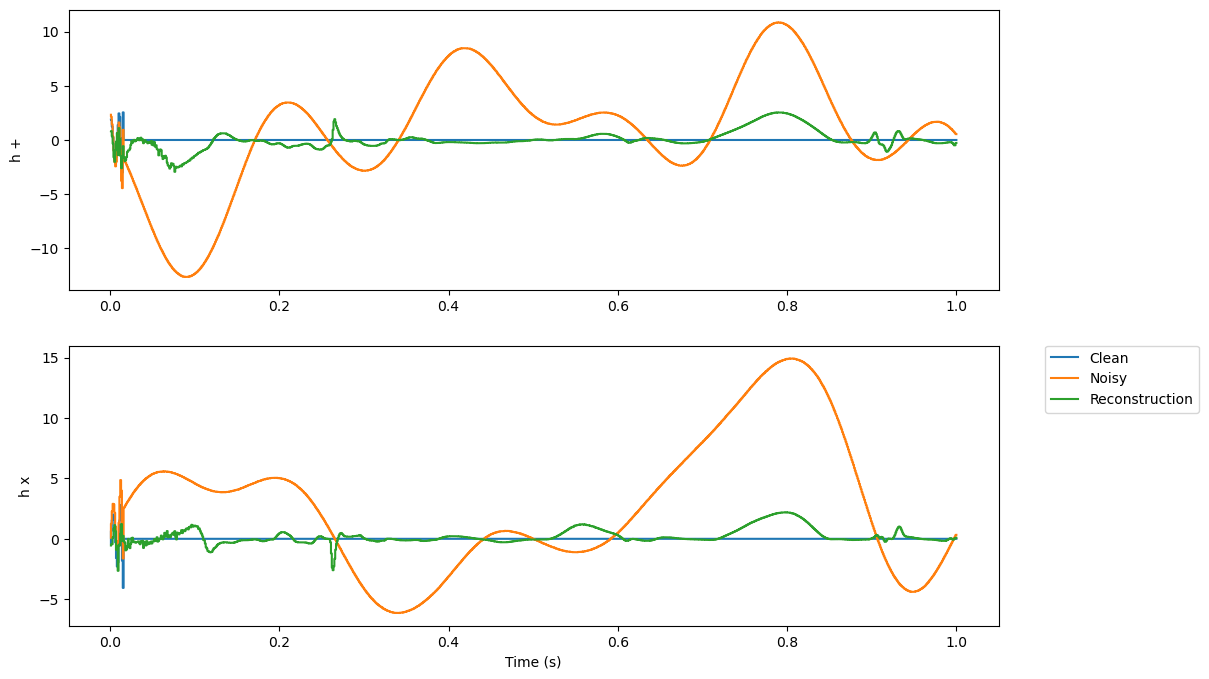

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.4592313766479492


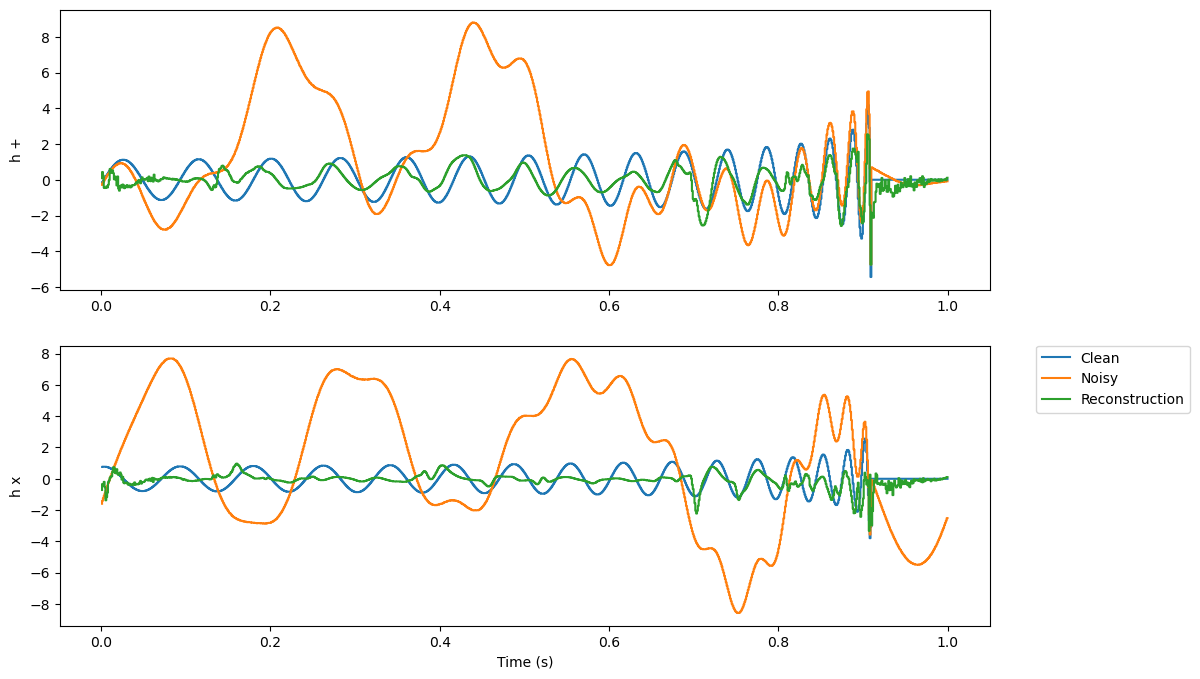

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Destination /tmp/checkpoints/checkpoint_9 already exists.

In [4]:
N_epochs = 10
batches_per_epoch = 1000
for epoch_idx, epoch_rng_key in tqdm(enumerate(jax.random.split(rng_key, N_epochs))):
    losses = []
    for batch_rng_key in tqdm(jax.random.split(epoch_rng_key, batches_per_epoch), leave=False):
        x, y = get_batch(batch_rng_key, batch_size)
        train_state, loss_value = optimization_step(train_state, x, y)
        losses.append(loss_value)

    checkpoints.save_checkpoint(ckpt_dir="/tmp/checkpoints", target=train_state, step=epoch_idx)
    print(f"Loss: {sum(losses) / len(losses)}")

    x, y = get_batch(epoch_rng_key, batch_size)
    out = train_state.apply_fn(train_state.params, x[0])
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.step(dataset.times, y[0][:, 0], label="Clean")
    plt.step(dataset.times, x[0][:, 0], label="Noisy")
    plt.step(dataset.times, out[:, 0], label="Reconstruction")
    plt.ylabel("h +")
    plt.subplot(2, 1, 2)
    plt.step(dataset.times, y[0][:, 1], label="Clean")
    plt.step(dataset.times, x[0][:, 1], label="Noisy")
    plt.step(dataset.times, out[:, 1], label="Reconstruction")
    plt.ylabel("h x")
    plt.xlabel("Time (s)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.show()